# Lab 3 (Part 1): Convolutional NNs for CIFAR 10

José María Martínez Marín 100443343

Azamat Ziiadinov 100460540

------------------------------------------------------
*Deep Learning. Master in Big Data Analytics*

*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this third lab of the lab, we will use a data set of (small) natural images known as  [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Our goal is to present i) how CNN layers are used in Pytorch, and ii) evaluate the performance of a simple CNN over this dataset.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

**IMPORTANT NOTE:** In this notebook I show you how to speed up NN training using Graphical Processing Units (GPUs). To make sure you use a Google Colaboratory server equipped with a GPU, go to `Edit` --> `Notebook Settings` --> Select GPU in `Hardware Accelerator`

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://pytorch.org/tutorials/_images/cifar10.png", width=400, height=300)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

## Part I. Download CIFAR10 with `torchvision`

The code below will download the MNIST dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [ ]:
import torch
from torchvision import datasets, transforms, utils

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(testset)

10000

In [ ]:
traindata = iter(trainloader)

images, labels = next(traindata)

print(images[1].shape)
print(images.shape)
print(labels.shape)

torch.Size([3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

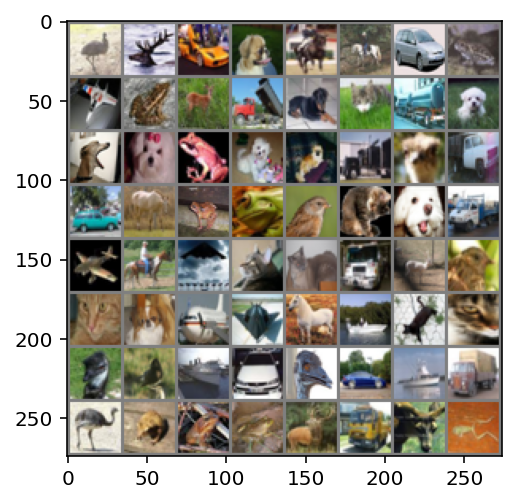

In [ ]:
imshow(utils.make_grid(images))


> **Exercise:** Create a validation set using the 20% of train images

In [ ]:
# YOUR CODE HERE
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 40k images for training
trainloader.dataset.data = trainloader.dataset.data[:40000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:40000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[40000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[40000:]



In [ ]:
print(len(trainloader.dataset.data))

40000


## Part II. Implement Lenet 5

Our first goal is to implement the LeNet 5 CNN network, first published in November 1998. See the original paper [here](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

In [ ]:
Image(url= "https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg")

In the CNN network above we have 2 convolutional layers with the following properties:

- ReLU activation functions are used as non-linear functions
- Maxpooling with $2\times 2$ kernels is used to reduce the spatial dimension in both layers.
- $5\times 5$ convolutional filters are used. Stride is 1.
- After the second convolutional layer, three dense layers are stacked. 

Note that CIFAR-10 images are composed by **3 input color maps**, each of dimension $32\times32$.

> **Exercise:** Complete the following code that defines the above CNN. But first read the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html) documentation.

In [ ]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)     
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)      
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)
        # Linear layers
        self.linear1 = nn.Linear(in_features = 16*5*5, out_features = 120) #      
        self.linear2 = nn.Linear(in_features = 120, out_features = 84) #       
        self.linear3 = nn.Linear(in_features = 84, out_features = 10) #
        self.relu = nn.ReLU()      
        self.logsoftmax = nn.LogSoftmax(dim=1)       
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) #YOUR CODE HERE
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(x.size(0), -1)
        # Pass the tensor through the Dense Layers
        x = self.linear1(x) 
        x = self.relu(x)
        x = self.linear2(x) 
        x = self.relu(x)
        x = self.linear3(x) 
        x = self.logsoftmax(x) 
        return x


Now the network is defined, by now you should know how to move forward by your own!!

> **Exercise:** Extend the class to incorporate a training method, to evaluate the both the validation and train losses and to evaluate the classification performance in a set.

In [ ]:
class Lenet5_extended(Lenet5):   
    
    def __init__(self,dimx,nlabels,epochs=30,lr=0.001):     
        super().__init__(dimx,nlabels)  #To initialize `MLP`!
        self.lr = lr #Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()              
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
        self.valid_loss_during_training = []
    
    def get_accuracy(self, data):
        accuracy = 0 
        with torch.no_grad():
            for images, labels in data:
                logprobs = self.forward(images)
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            print("Accuracy: %f" %(accuracy/len(data)))
            return

        
    def trainloop(self, trainloader, validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images)

                loss = self.criterion(out,labels)
                running_loss += loss.item()

                #Compute gradients
                loss.backward()
                
                #Perform one Adam step
                self.optim.step()
                
            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():
              running_loss = 0.    
              for (images, labels) in validloader:
                  out = self.forward(images)
                  loss = self.criterion(out, labels)
                  running_loss += loss.item()    
              self.valid_loss_during_training.append(running_loss/len(validloader))    

            if(e % 1 == 0): # Every 1 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                    %(e,self.valid_loss_during_training[-1]))


> **Exercise:** Train the model for 5 epochs, plot the train/validation loss during training, and compute the train and validation performance. It will take some time!!

In [ ]:
my_CNN = Lenet5_extended(dimx = 32, nlabels = 10, 
                   epochs = 5, lr = 1e-3)

my_CNN.trainloop(trainloader,validloader)

print("Train data:")
my_CNN.get_accuracy(trainloader)
print("Test data:")
my_CNN.get_accuracy(testloader)

Training loss after 0 epochs: 1.686833
Validation loss after 0 epochs: 1.510514
Training loss after 1 epochs: 1.405620
Validation loss after 1 epochs: 1.370947
Training loss after 2 epochs: 1.285723
Validation loss after 2 epochs: 1.280414
Training loss after 3 epochs: 1.205346
Validation loss after 3 epochs: 1.207525
Training loss after 4 epochs: 1.131219
Validation loss after 4 epochs: 1.181683
Train data:
Accuracy: 0.623625
Test data:
Accuracy: 0.588575


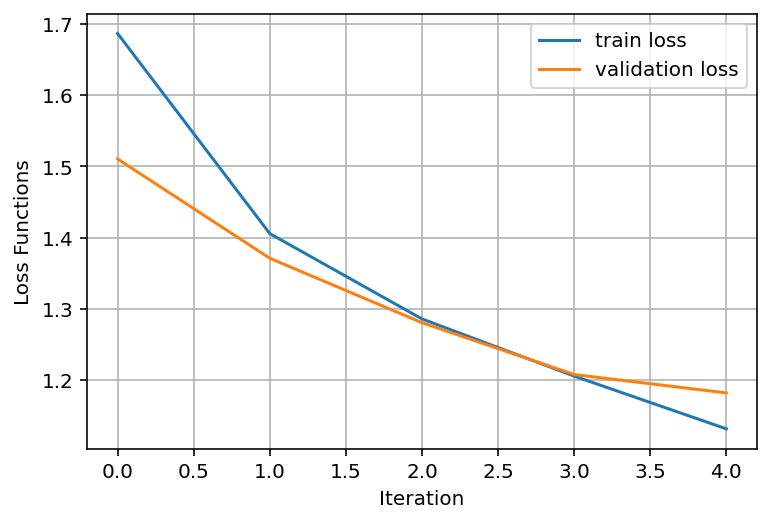

In [ ]:
plt.plot(my_CNN.loss_during_training)
plt.plot(my_CNN.valid_loss_during_training)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss Functions')
plt.legend(['train loss', 'validation loss'])

## Part III. GPU-based training

As you noticed, training became excessively slow. The newtork is already quite deep and gradient evaluation becomes a heavy operation. 

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

> **Exercise:** Complete the following class, which implements the CNN training and validation using a GPU (if possible). 

**Note: Google Colab Recommended**. When running the notebook in Google Colab, make sure you first to `Edit -- Notebook settings` and **select a GPU as Hardware accelerator.**



In [ ]:
class Lenet5_extended_GPU(Lenet5):
    
    #Your code here
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                #Reset Gradients!
                self.optim.zero_grad() #
            
                out = self.forward(images)

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Compute gradients
                #YOUR CODE HERE
                loss.backward() 
                #SGD stem
                #YOUR CODE HERE
                self.optim.step()
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device) #YOUR CODE HERE                                      
                    
                    # Compute output for input minibatch
                    out = self.forward(images) #YOUR CODE HERE

                    #Your code here
                    loss = self.criterion(out,labels) #YOUR CODE HERE

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            if(e % 1 == 0): # Every 10 epochs

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels =  images.to(self.device), labels.to(self.device)   #YOUR CODE HERE 
                probs = self.forward(images) #YOUR CODE HERE

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [ ]:
my_CNN_GPU = Lenet5_extended_GPU(dimx=32,nlabels=10,epochs=5,lr=1e-3)

my_CNN_GPU.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.722720, Validation loss: 1.500852, Time per epoch: 9.280638 seconds
Epoch 1. Training loss: 1.424598, Validation loss: 1.409022, Time per epoch: 9.243894 seconds
Epoch 2. Training loss: 1.309133, Validation loss: 1.293744, Time per epoch: 9.465064 seconds
Epoch 3. Training loss: 1.227025, Validation loss: 1.237564, Time per epoch: 9.211832 seconds
Epoch 4. Training loss: 1.160517, Validation loss: 1.217942, Time per epoch: 9.077233 seconds


tensor(0.5994)
tensor(0.5720)


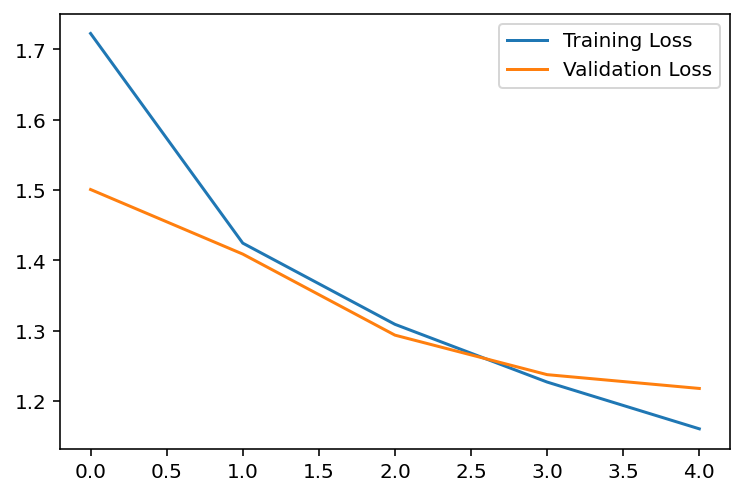

In [ ]:
plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_GPU.eval_performance(trainloader))
print(my_CNN_GPU.eval_performance(validloader))

With a GPU, you will see that the time per epoch roughly decreases significantly. As we train deeper and much more complex networks, **this difference grows exponentially fast**. Using GPUs is a must for lage-scale deployment.

## Part IV. Regularize the network and compare with a MLP

> **Exercise**: Now that you know how to train the CNN network, your goals are:
> - Check that the CNN is able to overfit
> - Regularize the network with both early stopping and dropout. In my experience, it is more efficient to include the dropout layers in between the final MLP layers, rather than in between convolutional layers. Note that once you include dropout, it wil take more epochs to converge. The more dropout layers, the more epochs typically you have to run. For this exercise, run at least 50 epochs.
> - Check the train/validation/test performance, plot the train and validation losses

In [ ]:
class Lenet5_extended_dropout(Lenet5):    
    #Your code here
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):      
        super().__init__(dimx,nlabels)         
        self.lr = lr #Learning Rate       
        self.optim = optim.Adam(self.parameters(), self.lr)       
        self.epochs = epochs       
        self.criterion = nn.NLLLoss()                   
        # A list to store the loss evolution along training     
        self.loss_during_training = []      
        self.valid_loss_during_training = []    
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)   

    def trainloop(self,trainloader,validloader):
        # Optimization Loop  
        for e in range(int(self.epochs)):    
            start_time = time.time()         
            # Random data permutation at each epoch       
            running_loss = 0.           
            for images, labels in trainloader:                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)          
                #Reset Gradients!
                self.optim.zero_grad()  #          
                out = self.forward(images)
                #Your code here
                loss = self.criterion(out,labels)
                running_loss += loss.item()
                loss.backward()                
                #Compute gradients
                self.optim.step() #               
                #SGD stem
                               
            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():  
                self.eval()                                      
                running_loss = 0.               
                for images,labels in validloader:                   
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device) #YOUR CODE HERE                                      
                    # Compute output for input minibatch
                    out = self.forward(images) #YOUR CODE HERE
                    #Your code here
                    loss = self.criterion(out,labels) #YOUR CODE HERE
                    running_loss += loss.item()                    
                self.valid_loss_during_training.append(running_loss/len(validloader))                 
            if(e % 1 == 0): # Every 10 epochs
                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
        self.train()                 


    def eval_performance(self,dataloader):     
        loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels =  images.to(self.device), labels.to(self.device)   #YOUR CODE HERE 
                probs = self.forward(images) #YOUR CODE HERE
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            return accuracy/len(dataloader)

In [ ]:
my_CNN_dropout = Lenet5_extended_dropout(dimx=32,nlabels=10,epochs=50,lr=1e-3)

my_CNN_dropout.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.680483, Validation loss: 1.481934, Time per epoch: 9.465482 seconds
Epoch 1. Training loss: 1.401289, Validation loss: 1.355421, Time per epoch: 9.371719 seconds
Epoch 2. Training loss: 1.286024, Validation loss: 1.298308, Time per epoch: 9.137319 seconds
Epoch 3. Training loss: 1.205033, Validation loss: 1.226404, Time per epoch: 9.320281 seconds
Epoch 4. Training loss: 1.137085, Validation loss: 1.189281, Time per epoch: 9.594015 seconds
Epoch 5. Training loss: 1.083938, Validation loss: 1.156792, Time per epoch: 9.267182 seconds
Epoch 6. Training loss: 1.040986, Validation loss: 1.121003, Time per epoch: 9.203440 seconds
Epoch 7. Training loss: 0.997487, Validation loss: 1.156425, Time per epoch: 9.237164 seconds
Epoch 8. Training loss: 0.960577, Validation loss: 1.104606, Time per epoch: 9.042350 seconds
Epoch 9. Training loss: 0.926977, Validation loss: 1.084464, Time per epoch: 9.088410 seconds
Epoch 10. Training loss: 0.900781, Validation loss: 1.089960

tensor(0.9088)
tensor(0.5936)


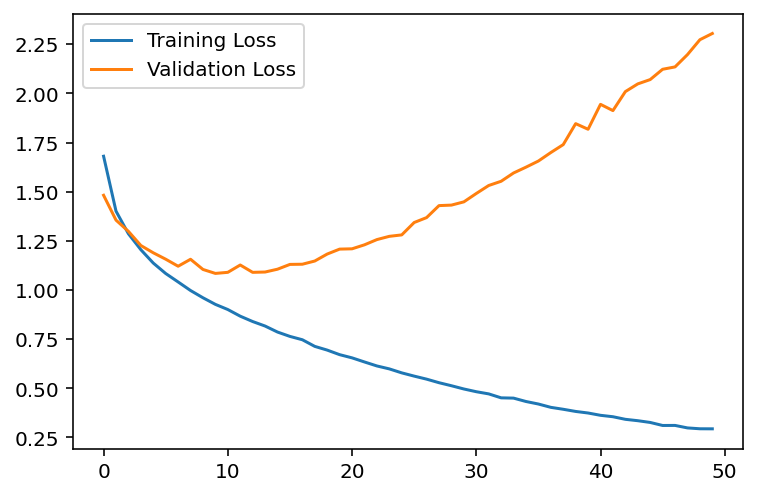

In [ ]:
plt.plot(my_CNN_dropout.loss_during_training,label='Training Loss')
plt.plot(my_CNN_dropout.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_dropout.eval_performance(trainloader))
print(my_CNN_dropout.eval_performance(validloader))

Graphs above show that, with dropout = 0.2, the validation loss decreases until a point where it stabilizes at the 12th epoch, and finally tends to increase. Early stopping should be set at this number of epochs, as overfitting is clearly seen.

### Train an MLP to compare the performance (Optional)

Train an MLP with 3-4 layers to compare the performance. Take into account that the input image has three color maps. If you stuck it into a vector, then the input dimension is 3x32x32 = 3072. An alternative is to compute the average between the three. Alternatively, you could use only one color map, or the average between three of them ...

In [ ]:
#YOUR CODE HERE

#YOUR CODE HERE

class Lenet5_MLP(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()    
        # Linear layers
        self.linear1 = nn.Linear(in_features = 400, out_features = 120) #      
        self.linear2 = nn.Linear(in_features = 120, out_features = 84) #       
        self.linear3 = nn.Linear(in_features = 84, out_features = 10) #
        self.relu = nn.ReLU()      
        self.logsoftmax = nn.LogSoftmax(dim=1)    
        self.dropout = nn.Dropout(p = 0.2)
        
    def forward(self, x):
        x = x.view(-1, 3*32*32)
        # Pass the tensor through the Dense Layers
        x = self.dropout(x)
        x = self.linear1(x) #
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x) #
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x) #
        x = self.logsoftmax(x) 
        return x

In [ ]:
class Lenet5_extended_MLP(Lenet5):    
    #Your code here
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):      
        super().__init__(dimx,nlabels)         
        self.lr = lr #Learning Rate       
        self.optim = optim.Adam(self.parameters(), self.lr)       
        self.epochs = epochs       
        self.criterion = nn.NLLLoss()                   
        # A list to store the loss evolution along training     
        self.loss_during_training = []      
        self.valid_loss_during_training = []    
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)   

    def trainloop(self,trainloader,validloader):
        # Optimization Loop  
        for e in range(int(self.epochs)):    
            start_time = time.time()         
            # Random data permutation at each epoch       
            running_loss = 0.           
            for images, labels in trainloader:                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)          
                #Reset Gradients!
                self.optim.zero_grad()  #          
                out = self.forward(images)
                #Your code here
                loss = self.criterion(out,labels)
                running_loss += loss.item()
                loss.backward()                
                #Compute gradients
                self.optim.step() #               
                #SGD stem
                #YOUR CODE HERE
                               
            self.loss_during_training.append(running_loss/len(trainloader))

  
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():  
                self.eval()                                      
                running_loss = 0.               
                for images,labels in validloader:                   
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device) #YOUR CODE HERE                                      
                    # Compute output for input minibatch
                    out = self.forward(images) #YOUR CODE HERE
                    #Your code here
                    loss = self.criterion(out,labels) #YOUR CODE HERE
                    running_loss += loss.item()                    
                self.valid_loss_during_training.append(running_loss/len(validloader))                 
            if(e % 1 == 0): # Every 10 epochs
                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
    # set model back to train mode
        self.train()                 


    def eval_performance(self,dataloader):     
        loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels =  images.to(self.device), labels.to(self.device)   #YOUR CODE HERE 
                probs = self.forward(images) #YOUR CODE HERE
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            return accuracy/len(dataloader)

In [ ]:
my_CNN_MLP = Lenet5_extended_MLP(dimx=32,nlabels=10,epochs=50,lr=1e-3)

my_CNN_MLP.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.708781, Validation loss: 1.481845, Time per epoch: 9.799795 seconds
Epoch 1. Training loss: 1.403562, Validation loss: 1.335828, Time per epoch: 9.816611 seconds
Epoch 2. Training loss: 1.287389, Validation loss: 1.272159, Time per epoch: 9.878103 seconds
Epoch 3. Training loss: 1.196997, Validation loss: 1.200181, Time per epoch: 9.810965 seconds
Epoch 4. Training loss: 1.124868, Validation loss: 1.152682, Time per epoch: 9.743603 seconds
Epoch 5. Training loss: 1.066297, Validation loss: 1.128097, Time per epoch: 9.825453 seconds
Epoch 6. Training loss: 1.018176, Validation loss: 1.124962, Time per epoch: 9.743377 seconds
Epoch 7. Training loss: 0.980334, Validation loss: 1.105174, Time per epoch: 9.942871 seconds
Epoch 8. Training loss: 0.940037, Validation loss: 1.125701, Time per epoch: 9.796563 seconds
Epoch 9. Training loss: 0.912670, Validation loss: 1.089455, Time per epoch: 9.703567 seconds
Epoch 10. Training loss: 0.872344, Validation loss: 1.077400

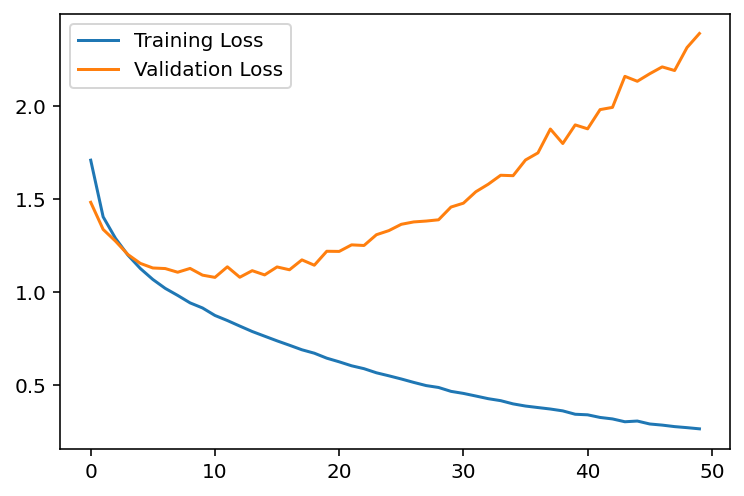

In [ ]:
plt.plot(my_CNN_MLP.loss_during_training,label='Training Loss')
plt.plot(my_CNN_MLP.valid_loss_during_training,label='Validation Loss')
plt.legend()

In [ ]:
print(my_CNN_MLP.eval_performance(trainloader))
print(my_CNN_MLP.eval_performance(validloader))

tensor(0.9190)
tensor(0.6062)


The validation loss decreases until the 10th epoch, when it starts to increase, therefore, early stop there would avoid overfitting in the sample causing the validation accuracy to be really low, really similarly to the previous case